# HNLQ: Part-04

In this series of notebooks, we will demonstrate **hierarchical nested lattice quantization** using the D4 lattice, showing how multi-level quantization can improve rate-distortion performance.

In this Part-04 notebook, we will look at q and M together.

In [1]:
import sys
sys.path.append('../../')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gemvq.quantizers.hnlq import HNLQ as Quantizer
from gemvq.quantizers.hnlq import HNLQConfig as QuantizerConfig

%load_ext autoreload
%autoreload 2

## Effect of q and M

Let's analyze how different values of q and number of levels M affect the quantization of a single sample:
- Quantization factors (q): 2, 4, 8
- Number of levels (M): 1, 2, 3, 4

This will help understand:
1. The impact of quantization factor on precision
2. How additional levels improve reconstruction
3. Trade-offs between q values and number of levels

In [2]:
# Create a single test sample
np.random.seed(42)  # For reproducibility

def run_quantization(q, M, test_sample):
    for m in range(1,M+1):
        quantizer = Quantizer.create_d4_quantizer(q=q,M=m)
        enc, T = quantizer.encode(test_sample)
        xh = quantizer.decode(enc,T, with_dither=False)
        error = np.linalg.norm(test_sample - xh)
        print(f"\t Depth x: {m}")
        print(f"\t De-quantized x: {xh}")
        print(f"\t Error (L2 norm): {error:.2f}")
        print(f"\t Overload Factor : {T}")

d = 4
q = 4
M = 5
print(f" q = {q}, M= {M}")


scale = q**(0)
test_sample = scale*np.random.uniform(-1,1,size=d)
print("Original Sample:", np.round(test_sample, 3))
run_quantization(q, M, test_sample)

scale = q**(M)
test_sample = scale*np.random.uniform(-1,1,size=d)
print("Original Sample:", np.round(test_sample, 3))
run_quantization(q, M, test_sample)


 q = 4, M= 5
Original Sample: [-0.251  0.901  0.464  0.197]
	 Depth x: 1
	 De-quantized x: [0. 1. 1. 0.]
	 Error (L2 norm): 0.63
	 Overload Factor : 0
	 Depth x: 2
	 De-quantized x: [0. 1. 1. 0.]
	 Error (L2 norm): 0.63
	 Overload Factor : 0
	 Depth x: 3
	 De-quantized x: [0. 1. 1. 0.]
	 Error (L2 norm): 0.63
	 Overload Factor : 0
	 Depth x: 4
	 De-quantized x: [0. 1. 1. 0.]
	 Error (L2 norm): 0.63
	 Overload Factor : 0
	 Depth x: 5
	 De-quantized x: [0. 1. 1. 0.]
	 Error (L2 norm): 0.63
	 Overload Factor : 0
Original Sample: [-704.474 -704.523 -905.045  749.929]
	 Depth x: 1
	 De-quantized x: [-1024. -1024. -1024.  1024.]
	 Error (L2 norm): 541.69
	 Overload Factor : 10
	 Depth x: 2
	 De-quantized x: [-768. -768. -768.  768.]
	 Error (L2 norm): 164.84
	 Overload Factor : 8
	 Depth x: 3
	 De-quantized x: [-704. -704. -896.  768.]
	 Error (L2 norm): 20.22
	 Overload Factor : 6
	 Depth x: 4
	 De-quantized x: [-704. -704. -912.  752.]
	 Error (L2 norm): 7.29
	 Overload Factor : 4
	 Depth 

## Commentary

When the input norm is small, a fixed $q$ already yields $T=0$ (no overload scaling). In that regime, using depth $M>1$ brings little to no benefit: higher layers mostly quantize to the zero codeword, so you spend bits without reducing error. 

When the input norm is larger, increasing \(M\) continues to refine the reconstruction,
$$
\hat{x} \;=\; \sum_{m=0}^{M-1} q^{m}\,\hat{x}_m,\qquad \hat{x}_m \in A_q,
$$

and the quantization error drops as more layers are added.

A bit-plane analogy helps: for small magnitudes the higher bit-planes are zero anyway (extra planes don’t help), whereas for larger magnitudes, additional planes capture more detail and reduce error.

**Effect of $q$**

Raising $q$ enlarges the base codebook \(A_q = L \cap (q V_L)\) and the capture range (roughly proportional to \(q\,R_{\mathrm{in}}(L)\)), so it can substantially reduce error for larger inputs. The trade-off is a higher rate and more memory/compute (e.g., LUT size grows like \(|A_q|^2 = q^{2d}\)).

**Overload factor $T$**

The overload factor $T$ is the number of scale doublings used to avoid overload. We pick $\beta = \beta_0\,2^T$ so that $Q_L(x/\beta)\in q V_L$. Thus:
- $T=0$: the unscaled input is already admissible (no overload).
- $T>0$: we had to enlarge $\beta$; after scaling there’s no overload, but the granular floor \(\approx \beta^2\sigma^2(L)\) is higher when $T$ is larger.

**Monotonicity**

- For **fixed $q$** (and fixed \(\beta\)), distortion is **monotone non-increasing in \(M\)**: extra layers cannot hurt; they may just have negligible effect when inputs are small.
- Across **different $q$**, nesting is not preserved in general (e.g., $(q{=}2,M{=}1)$ is not necessarily nested in $(q{=}4,M{=})$, so error need not be monotone in $q$. Still, holding other factors fixed, larger $q$ typically lowers error **on average** at the cost of higher rate and compute.




Summary of Average Reconstruction Errors (L2 norm):
          1         2         3
2  1.477454  1.370284  1.343476
4  0.695483  0.638261  0.636757
8  0.633247  0.637115  0.647050


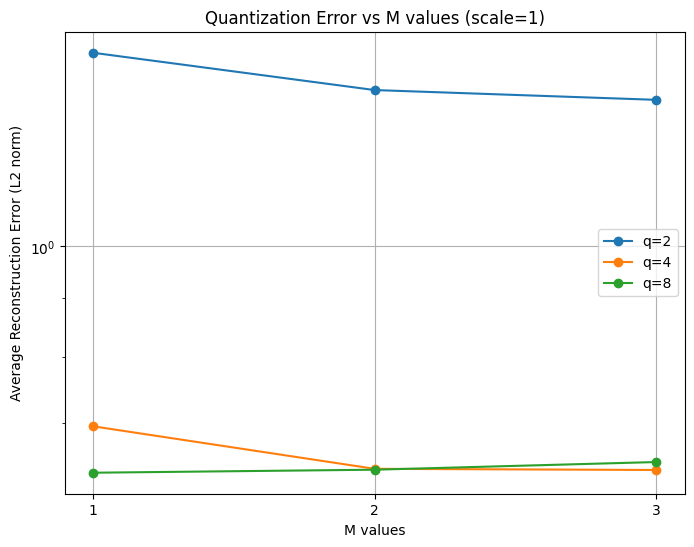


Summary of Average Reconstruction Errors (L2 norm):
           1          2         3
2  11.433479  10.372707  9.901014
4   4.531981   1.206869  0.635178
8   2.250754   0.645559  0.639362


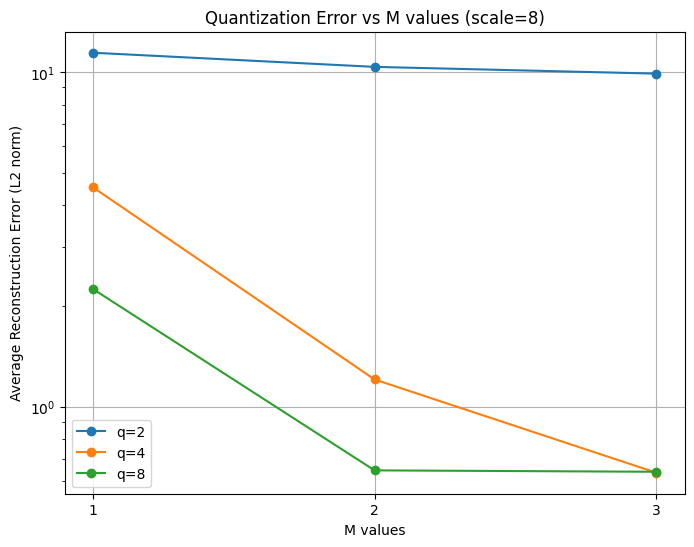

/Users/somadhavala/work/mlsquare/gemvq/docs/notebooks/../../gemvq/quantizers/hnlq.py:351: UserWarning: Overload not resolved after 10 iterations. Consider increasing max_scaling_iterations or adjusting parameters.
  warnings.warn(



Summary of Average Reconstruction Errors (L2 norm):
            1           2           3
2  401.268183  452.641001  504.599741
4  146.419928   37.371035    9.362402
8   70.851183    8.910266    1.117961


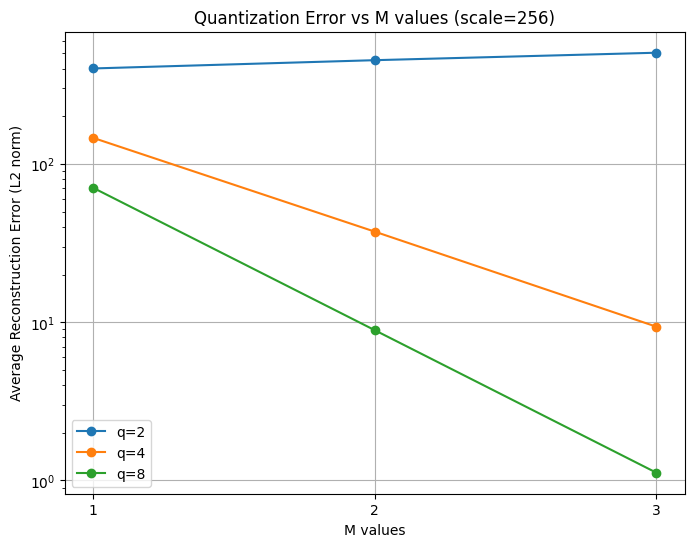

In [3]:
# Refactored evaluate_quantization function for the new HNLQ module

def evaluate_quantization(scale=1, q_values=[2,4,8], m_values=[1,2,3], N=1000):
    """
    Evaluate quantization performance across different q and M values.
    
    Parameters:
    -----------
    scale : float
        Scale factor for input vectors
    q_values : list
        List of quantization parameters to test
    m_values : list
        List of hierarchical levels to test
    N : int
        Number of test samples for averaging
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from gemvq.quantizers.hnlq import HNLQ, HNLQConfig
    
    # Initialize error matrix
    er = np.zeros((len(q_values), len(m_values)))
    
    for i, q in enumerate(q_values):
        for j, m in enumerate(m_values):
            
            # Create HNLQ configuration
            config = HNLQConfig(
                lattice_type='D4',
                q=q,
                M=m,
                beta=1.0,
                alpha=1.0,
                eps=1e-8,
                overload=True,
                decoding='full',
                max_scaling_iterations=10,
                with_tie_dither=True,
                with_dither=False
            )
            
            # Initialize quantizer with configuration
            quantizer = HNLQ(config)
            
            # Test N samples
            for n in range(N):
                # Generate test sample
                test_sample = scale * np.random.normal(0, 1, size=4)
                
                # Encode and decode
                enc, T = quantizer.encode(test_sample, with_dither=False)
                xh = quantizer.decode(enc, T, with_dither=False)
                
                # Calculate error
                error = np.linalg.norm(test_sample - xh)
                er[i, j] += error
            
            # Average over N samples
            er[i, j] /= N
    
    # Create results DataFrame
    df = pd.DataFrame(er, index=q_values, columns=m_values)
    print("\nSummary of Average Reconstruction Errors (L2 norm):")
    print(df)
    
    # Create visualization
    plt.figure(figsize=(8, 6))
    
    for i, q in enumerate(q_values):
        plt.plot(m_values, er[i], marker='o', label=f'q={q}')
    
    plt.xlabel('M values')
    plt.ylabel('Average Reconstruction Error (L2 norm)')
    plt.title(f'Quantization Error vs M values (scale={scale})')
    plt.xticks(m_values)
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return df

# Example usage:
# df_results = evaluate_quantization(scale=1, q_values=[2,4,8], m_values=[1,2,3], N=1000)

# Try different M values
results = evaluate_quantization(scale=1, q_values=[2,4,8], m_values=[1,2,3])

# Try different scales
results = evaluate_quantization(scale=2**3, q_values=[2,4,8], m_values=[1,2,3])

# Try different scales
results = evaluate_quantization(scale=2**8, q_values=[2,4,8], m_values=[1,2,3])

## Take-aways

So, increasing q increases the codebook size, and therefore, the rate, but it also allows for finer quantization at each level, which can reduce distortion. When the norm of the input is large, the reduction in distortion from increasing q can be significant. However, when the norm of the input is small, the benefit of increasing q may be less pronounced.

Both q and M affect the rate-distortion trade-off, but in different ways. Increasing q increases the codebook size and rate, while increasing M allows for finer quantization at the cost of complexity. The optimal choice of q and M depends on the specific application and the characteristics of the input data. Arbitrarily increasing either q or M will not always lead to better performance, and there are diminishing returns as these parameters are increased.

So, the norm of the input vector plays a crucial role in determining the effectiveness of increasing M and q in hierarchical lattice quantization. In particular, for the target rate of $R=M \log_2(q)$ per dimension. if the norm is $q^M$, both increasing q and M can significantly reduce distortion. However, if the norm is much smaller than $q^M$, increasing M may have limited benefits, while increasing q can still help reduce distortion. However, monotonicity is not guaranteed.